# Two-stream instability

1D simulation of the Two-Stream instability using an eletromagnetic code with a spectral (pseudo-spectral analytic time domain) code.

In [1]:
import em1ds as zpic
import numpy as np

nx = 120
dt = 0.1

ppc = 500
ufl = [0.2,    0.0,  0.0]
uth = [0.001,0.001,0.001]

right = zpic.Species( "right", -1.0, ppc, ufl = ufl, uth = uth )

ufl[0] = -ufl[0]
left  = zpic.Species( "left", -1.0, ppc, ufl = ufl, uth = uth )

sim = zpic.Simulation( nx, box = 4 * np.pi, dt = dt, species = [right,left] )
sim.emf.solver_type = "PSATD"

## Running the simulation

We will be running the simulation well beyond the saturation of the instability (for the default parameters this happens around $t = 20 \, \omega_n^{-1}$). We will be recording the longitudinal component of the electric field for later analysis. 

In [2]:
tmax = 60

niter = int(tmax / dt)

Ex_t = np.zeros((nx,niter))

print("\nRunning simulation up to t = {:g} ...".format(tmax))
while sim.t < tmax:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ex_t[:,sim.n] = sim.emf.Ex
    sim.iter()

print("\nDone.")


Running simulation up to t = 60 ...
n = 599, t = 59.9
Done.


## Time evolution of the electric field

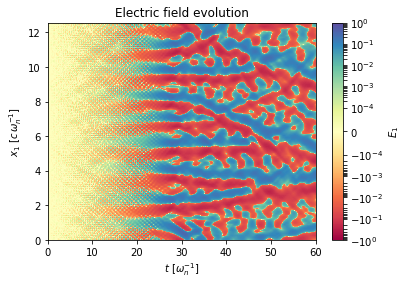

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

range = [[0,tmax],[0,sim.box]]


plt.imshow( Ex_t, interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
         norm=colors.SymLogNorm(base=10,linthresh = 0.0001, vmin=-1, vmax=1),
          aspect = 'auto', cmap = 'Spectral')

plt.colorbar().set_label('$E_1$')
plt.xlabel("$t$ [$\omega_n^{-1}$]")
plt.ylabel("$x_1$ [$c\,\omega_n^{-1}$]")
plt.title("Electric field evolution")

plt.show()

## Time evolution of the power spectrum

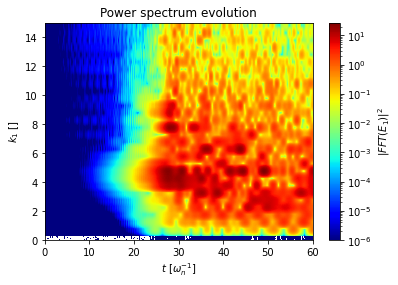

In [5]:
sp = (np.abs( np.fft.rfft2(Ex_t,axes = (0,) ) )**2)[:sim.nx//4,:]

kmax = np.pi / (sim.box / sim.nx)
img_range = [[0,tmax],[0,kmax/2]]

plt.imshow( sp, origin = 'lower', 
            extent = ( img_range[0][0], img_range[0][1], img_range[1][0], img_range[1][1] ),
            norm=colors.LogNorm(vmin = 1e-6),
            aspect = 'auto', cmap = 'jet')

plt.colorbar().set_label('$|FFT(E_1)|^2$')

plt.xlabel("$t$ [$\omega_n^{-1}$]")
plt.ylabel("$k_1$ []")
plt.title("Power spectrum evolution")

plt.show()

## Electric field energy evolution

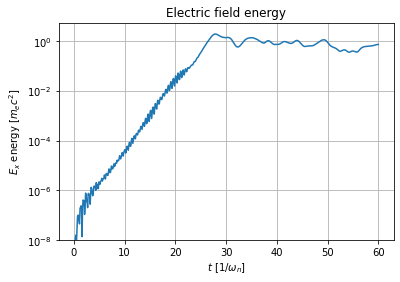

In [6]:
import matplotlib.pyplot as plt

Ex_ene = np.sum(Ex_t**2, axis = 0)

plt.plot(np.linspace(0, sim.t, num = sim.n),Ex_ene)
plt.yscale('log')
plt.ylim(ymin=1e-8)
plt.grid(True)
plt.xlabel("$t$ [$1/\omega_n$]")
plt.ylabel("$E_x$ energy [$m_e c^2$]")
plt.title("Electric field energy")
plt.show()

## Final particle phasespace

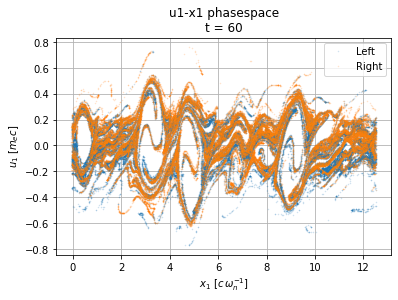

In [7]:
# Simple function to convert particle positions
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(left),  left.particles['ux'],  '.', ms=1,alpha=0.2, label = "Left")
plt.plot(x(right), right.particles['ux'], '.', ms=1,alpha=0.2, label = "Right")
plt.xlabel("$x_1$ [$c\,\omega_n^{-1}$]")
plt.ylabel("$u_1$ [$m_e c$]")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.legend()
plt.grid(True)
plt.show()